#Autoencoder and Denoising Autoencoder on MNIST dataset

Deep Autoencoder on MNIST

In [1]:
#1)

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("Training data shape: ", x_train.shape)
print("Training labels shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test labels shape: ", y_test.shape)

# Normalizing
x_train = x_train / 255.0
x_test = x_test / 255.0

# Checking first elements in x_train
print("First element in x_train: ", x_train[0])

11490434/11490434 [==============================] - 0s 0us/step
Train data shape:  (60000, 28, 28)
Train labels shape:  (60000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)
First element in x_train:  [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.

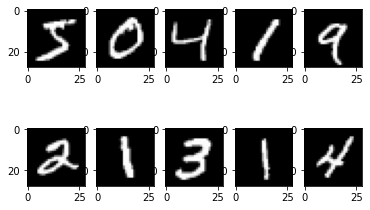

In [2]:
#2)

import matplotlib.pyplot as plt

# Plot 10 random images from the x_train dataset
sample = x_train[:10]
for i, image in enumerate(sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray')

plt.show()

In [3]:
#3)
from keras.models import Model
from keras.layers import Input, Dense, ReLU, Dropout

LATENT_SIZE = 32

input_img = Input(shape=(28, 28))

# Encoder model
x = Dense(512, activation='relu')(input_img)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
encoded = Dense(LATENT_SIZE, activation='relu')(x)

encoder = Model(input_img, encoded)

In [4]:
#4)

from tensorflow.keras.layers import Dense, ReLU, Dropout, Reshape
from tensorflow.keras import Model

class Decoder(Model):
    def __init__(self, latent_size=32):
        super(Decoder, self).__init__()
        self.dense1 = Dense(7 * 7 * 64, activation='relu')
        self.dropout1 = Dropout(0.5)
        self.dense2 = Dense(14 * 14 * 32, activation='relu')
        self.dropout2 = Dropout(0.5)
        self.dense3 = Dense(28 * 28 * 16, activation='relu')
        self.dropout3 = Dropout(0.5)
        self.dense4 = Dense(28 * 28, activation='sigmoid')
        self.reshape = Reshape((28, 28))

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        x = self.dense3(x)
        x = self.dropout3(x)
        x = self.dense4(x)
        x = self.reshape(x)
        return x


In [ ]:
#5) 

from keras.models import Model
from tensorflow.keras.layers import Input


img = Input(shape = (28, 28)) 
latent_vector = encoder(img)
output = Decoder(latent_vector)
model = Model(inputs = img, outputs = output)
model.compile("nadam", loss = "binary_crossentropy")

In [10]:
import tensorflow as tf

class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(CustomLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[-1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(CustomLayer, self).build(input_shape)
    
    def call(self, inputs):
        return tf.matmul(inputs, self.kernel)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)



In [11]:

inputs = tf.keras.layers.Input(shape=(28, 28))
latent_vector = CustomLayer(output_dim=32)(inputs)
outputs = CustomLayer(output_dim=10)(latent_vector)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='nadam', loss='binary_crossentropy')


In [ ]:
#6)

from keras.models import Model
import numpy as np

x_train = np.reshape(x_train, (x_train.shape[0], 28, 28))
EPOCHS = 60
for epoch in range(EPOCHS):
  model.fit(x_train, x_train)



Denoising autoencoder on MNIST

In [17]:
#7)

import numpy as np
np.random.seed(20201007)
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
x_train_noisy = np.clip(x_train_noisy, 0, 1)

In [18]:
#8)

noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise
x_test_noisy = np.clip(x_test_noisy, 0, 1)

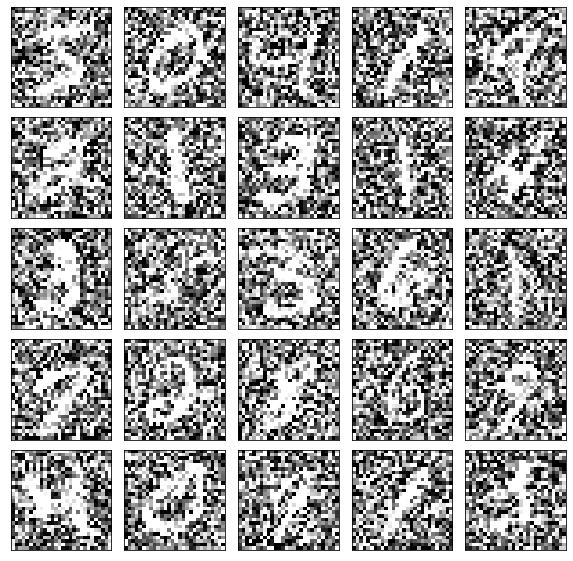

In [19]:
#9)

import matplotlib.pyplot as plt

# plot some of the noisy images
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train_noisy[i], cmap='gray')

plt.show()

In [ ]:
#10) : Results are not really convincing.

In [ ]:
#11)

import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from tensorflow.keras import layers
import numpy as np

class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        e = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * e

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 14, 32)   320         ['input_22[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_4[0][0]']               
                                                                                                  
 flatten_2 (Flatten)            (None, 3136)         0           ['conv2d_5[0][0]']               
                                                                                            

In [ ]:
#12)

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_41 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_9 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        289 

In [ ]:
#13)

autoencoder = Model(encoder_inputs, decoder(encoder(encoder_inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          69076       ['input_22[0][0]']               
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    65089       ['encoder[0][0]',                
                                                                  'encoder[0][1]',      

In [ ]:
#14)

autoencoder.compile(loss='mse', optimizer='adam')